<a href="https://colab.research.google.com/github/kofibeans/APM1111---SA2/blob/main/AQUINO_SA2_1_Rats_and_Spontaneous_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rats and Spontaneous Exploration: One-Way ANOVA**

**Data Description**

A cognitive psychologist was interested in the impact of 2 - dimensional visual stimuli on the spontaneous exploration behavior in rats.   Thirty-six (n = 36) rats were selected to participate and randomly assigned to three treatment conditions:

* Visual images of shapes
* Visual images of patterns
* Visual images that used pictures

Rats were released into a chamber and the number of seconds the rats spent exploring the experimental chamber with the images were recorded.

**Directions**
1. Download the Rats and Spontaneous Exploration data set.
2. Provide a full analysis using one of the ANOVA types to compare the number of seconds the rats spent exploring the experiment chamber with the images. Is there a significant difference in time spent between the three treatment conditions: shapes, patterns, and pictures?
3. Check the assumptions underlying the chosen ANOVA type.
4. Make a report in APA format, including the checking of the assumptions.
5. Provide a Github link to your file answering this problem. (5 points will be automatically deducted if without a Github link.)

*Note*:

* Use Jupyter Notebook or R Studio with the proper formatting of your markdown and code. You may check your results using JASP.
* Upload a Word file containing your Github link to your file or upload your R output or Python output using the tool below.
* Be sure that your outputs/files already contain the results of your analysis and I don't have to run your code to check the output results. (Minus 5 if I still have to run your code to check your outputs.)

## **Exploratory Data Analysis**

### **Environment Set-Up**

The following code is written in Python. The libraries are pre-written functionaility to perform necessary tasks.

In [ ]:
# import libraries

# general setup and libraries
import io
import sys # access to system parameters
import os  # os-related functionalities
import numpy as np  # numerical computation
import pandas as pd  # data manipulation and statistical analysis

# data visualization
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # data visualization based on matplotlib
import pprint
import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

# statistical models and testing
import statsmodels.formula.api as smf  # statistical models using formulas
import statsmodels.api as sm  # statistical models and hypothesis testing
from scipy import stats  # scientific computing and statistical functions

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


### **Data Preparation**

#### **Import Data**

In [ ]:
path = 'https://raw.githubusercontent.com/kofibeans/APM1111---SA2/main/RatExploration_csvFile.csv'

def load(path, info = True):
  if len(path.split(".csv")) > 1:
    read = pd.read_csv(path)
  elif len(path.split(".xlsx")) > 1:
    read = pd.read_excel(path)

  if info:
    if len(read) > 0:
      print("# Dimensions")
      print("Observation:", read.shape[0], "Column:", read.shape[1], "\n")
      print("# Dtypes")
      if len(read.select_dtypes("object").columns) > 0:
        print("-- Object Variables: ",
        len(read.select_dtypes("object").columns), " ",
        read.select_dtypes("object").columns.tolist(), "")

      if len(read.select_dtypes("integer").columns) > 0:
        print("-- Integer Variables: ",
        len(read.select_dtypes("integer").columns), " ",
        read.select_dtypes("integer").columns.tolist(), "")

      if len(read.select_dtypes("float").columns) > 0:
        print("-- Float Variables:",
        len(read.select_dtypes("float").columns), " ",
        read.select_dtypes("float").columns.tolist(), "")

      if len(read.select_dtypes("bool").columns) > 0:
         print("-- Bool Variables:",
        len(read.select_dtypes("bool").columns), " ",
        read.select_dtypes("bool").columns.tolist(), "")

      print("\n# Missing Value")
      print("-- Are there any missing values? ", np.where(read.isnull().values.any() == False, "[No missing value!]", "[Data includes missing value!]"), "\n")
      buf = io.StringIO()
      read.info(buf=buf)
      info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
      print("# Memory Usage: ", info, "\n")

    else:
      print("# Data did not import!")

  return read

data = load(path, info = True)

# Dimensions
Observation: 36 Column: 3 

# Dtypes
-- Object Variables:  1   ['Stimuli'] 
-- Integer Variables:  1   ['ID'] 
-- Float Variables: 1   ['Time'] 

# Missing Value
-- Are there any missing values?  [No missing value!] 

# Memory Usage:  992.0+ bytes 



### **Descriptive Statistics**

In [ ]:
def coefficient_of_variation(x):
    mean_value = x.mean()
    std_dev = x.std()
    if mean_value != 0:
        return (std_dev / mean_value)
    else:
        return np.nan

summary = (
    data.groupby('Stimuli')
    .agg(
      N = ('Time', 'count'),
      Min = ('Time', 'min'),
      Q1 = ('Time', lambda x: x.quantile(0.25)),
      Median = ('Time', 'median'),
      Mean = ('Time', np.mean),
      SD = ('Time', 'std'),
      SE = ('Time', lambda x: np.std(x, ddof = 1) / np.sqrt(len(x))),
      CV  =('Time', coefficient_of_variation),
      Q3 = ('Time', lambda x: x.quantile(0.75)),
      Max = ('Time', 'max')
    )
)

# display the styled df
summary.style.set_precision(3)

,N,Min,Q1,Median,Mean,SD,SE,CV,Q3,Max
Stimuli,,,,,,,,,,
Pattern,12,1.850,2.500,3.025,2.887,0.684,0.197,0.237,3.250,4.100
Picture,12,3.050,3.612,4.175,3.954,0.608,0.175,0.154,4.287,5.000
Shape,12,0.500,0.938,1.250,1.250,0.489,0.141,0.391,1.562,2.000


## **Assumption Check**

The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

### **Assumptions 1 - 3**

**Assumption 1:** You have one dependent variable that is measured at the continuous level.

> ***Remark.*** The dependent variable was called `time` and is a continuous level.

**Assumption 2:** You have one independent variable that consists of two categorical, independent
groups.

> ***Remark.*** The independent variable is the `stimuli` which is categorized into independent groups: pattern, picture, and shape.

**Assumption 3:** You should have independence of observations.

> ***Remark.*** Each observation is independent with each other as there is no relationship between the observations in each group of the independent variable or between the groups themselves.

### **Assumption 4: Outliers**

There should be no significant outliers in the groups of your independent variable in terms of the dependent variable.

####**Outlier Detection Through Box-plot**

To visually inspect outliers through box-plots, observe the points beyond the "whiskers" of the boxplot.

<Axes: xlabel='Stimuli', ylabel='Time'>

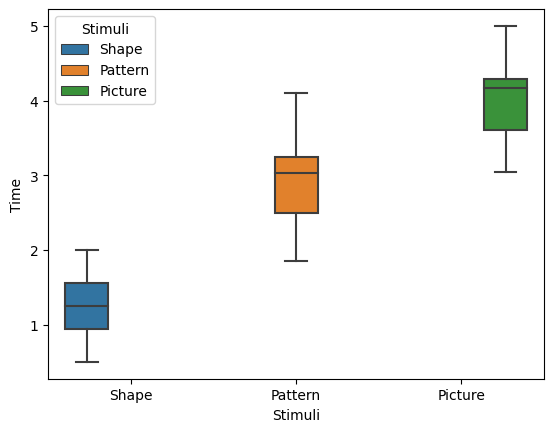

In [ ]:
sns.boxplot(x = 'Stimuli', y = 'Time', hue = 'Stimuli', data = data)

####**Outlier Detection Through z-score**

To identify outliers using the z-score, we can set a threshold value by 3. Data points with a z-score greater than 3 or less than -3 can be considered an *extreme* outlier.

In [ ]:
from scipy.stats import zscore

def identify_outliers(group):
    z_scores = zscore(group['Time'])
    outliers = (z_scores > 3) | (z_scores < -3)
    return group[outliers]

outliers = data.groupby(['Stimuli']).apply(identify_outliers)

# display the styled df
outliers.style

,,ID,Stimuli,Time
Stimuli,,,,



> ***Remark.*** There were no extreme outliers.

### **Assumption 5: Normality**

Your **dependent variable** should be **approximately normally distributed for each combination of the groups of your two factors** (i.e., your within-subjects factor and between-subjects factor).

In [ ]:
from scipy.stats import shapiro

# checking the normality assumption for each group using Shapiro-Wilk test
group_0 = data[data['Stimuli'] == 'Pattern']['Time']
group_1 = data[data['Stimuli'] == 'Picture']['Time']
group_2 = data[data['Stimuli'] == 'Shape']['Time']

shapiro_0 = stats.shapiro(group_0)
shapiro_1 = stats.shapiro(group_1)
shapiro_2 = stats.shapiro(group_2)

# creating a table for the Shapiro-Wilk test results
results = pd.DataFrame({'Stimuli': ['Pattern', 'Picture', 'Shape'],
                        'W-statistic': [shapiro_0.statistic, shapiro_1.statistic, shapiro_2.statistic],
                       'p-value': [shapiro_0.pvalue, shapiro_1.pvalue, shapiro_2.pvalue]})

print("\nTest of Normality (Shapiro-Wilk)")
results.style.set_precision(3)


Test of Normality (Shapiro-Wilk)


,Stimuli,W-statistic,p-value
0,Pattern,0.950,0.638
1,Picture,0.915,0.248
2,Shape,0.944,0.548



> The data was normally distributed (p \> 0.05), as assessed by Shapiro-Wilk's test of normality.

### **Assumption 6: Homogeneity of Variance**

There needs to be **homogeneity of variances for each combination of the groups of your two factors** (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [ ]:
# perform levene test
lt_results = stats.levene(group_0, group_1, group_2, center = 'mean')

# create a dictionary with the results
results = {
    'F': lt_results.statistic,
    'df1': [3 - 1],
    'df2': [len(group_0) + len(group_1) + len(group_2) - 3],
    'p': lt_results.pvalue
}
# create a dataframe with the results
results_lt = pd.DataFrame(results)

# print and style the dataframe
print("\n Test of Equality of Variances")
results_lt.style.set_precision(3)


 Test of Equality of Variances


,F,df1,df2,p
0,0.774,2,33,0.469




> There was homogeneity of variances for all cells (p \> 0.05), as assessed by Levene's test of homogeneity of variance.



## **ANOVA Testing and Computation**

In [58]:
from statsmodels.formula.api import ols

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['p_eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'p_eta_sq']
    aov = aov[cols]
    return aov

model = ols('Time ~ Stimuli', data = data).fit()
aov_table = sm.stats.anova_lm(model, typ = 2)

# display the styled df
print("\n ANOVA")
anova_table(aov_table).style.set_precision(3)


 ANOVA


,sum_sq,df,mean_sq,F,PR(>F),p_eta_sq
Stimuli,44.527,2.000,22.263,62.089,0.000,0.790
Residual,11.833,33.000,0.359,nan,nan,nan


**Post-Hoc Testing**

By conducting post-hoc tests or planned comparisons it allows one to see which group(s) significantly differ from each other.

In [55]:
import statsmodels.stats.multicomp as smm

# perform tukey's HSD test
one_tukey_smm = smm.pairwise_tukeyhsd(endog=data['Time'], groups=data['Stimuli'])

# convert the results to a df
tukey_df = pd.DataFrame(data=one_tukey_smm._results_table.data[1:], columns
 =one_tukey_smm._results_table.data[0])

# display the styled df
tukey_df.style.set_precision(3)

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Pattern,Picture,1.067,0.000,0.467,1.667,True
1,Pattern,Shape,-1.637,0.000,-2.237,-1.038,True
2,Picture,Shape,-2.704,0.000,-3.304,-2.104,True




> Using Tukey HSD, there a significant difference in time spent between the three treatment conditions: shapes, patterns, and pictures.



## **Reporting**

A one-way ANOVA was conducted to evaluate if there is a significant difference in time spent between the three treatment conditions. Stimuli were classified into three groups: shapes (n = 12), patterns (n = 12),and pictures (n = 12).

There were no outliers, as assessed by visual inspection of boxplot; data was normally distributed for each group, as assessed by Shapiro-Wilk test (p > .05); and there was homogeneity of variances, as assessed by Levene's test of homogeneity of variances (p = .469). Data is presented as mean ± standard deviation.

The number of seconds the rats spent in chamber was statistically significantly different between each stimuli, F(2, 33) = 62.089, p < 0.001, with a small effect size (η²p = 0.26).